In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

In [2]:
df = pd.read_csv('df_salary.csv')
df = df.dropna(subset=['SALARY'])
print(f"Data Loaded: {df.shape}")

Data Loaded: (96223, 80)


In [3]:
bins = [-1, 30000, 60000, 90000, 150000, float('inf')]
labels = ['0-30k', '30k-60k', '60k-90k', '90k-150k', 'Special/Other']

In [4]:
df['Salary_Group'] = pd.cut(df['SALARY'], bins=bins, labels=labels)

print("\nTarget Class Distribution:")
print(df['Salary_Group'].value_counts())

# --- Preprocessing ---
target_col = 'Salary_Group'
df = df.dropna(subset=[target_col])
class_counts = df[target_col].value_counts()
print("\nClass Counts before filtering:")
print(class_counts)

rare_classes = class_counts[class_counts < 2].index

if len(rare_classes) > 0:
    print(f"\nRemoving rare classes (count < 2): {list(rare_classes)}")
    # Filter out the rare rows
    df = df[~df[target_col].isin(rare_classes)]

X = df.drop(['SALARY', 'Salary_Group'], axis=1)
y = df[target_col]

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# One-hot encode features
X = pd.get_dummies(X, drop_first=True)


Target Class Distribution:
Salary_Group
30k-60k          41434
Special/Other    19131
0-30k            14549
60k-90k          14391
90k-150k          6718
Name: count, dtype: int64

Class Counts before filtering:
Salary_Group
30k-60k          41434
Special/Other    19131
0-30k            14549
60k-90k          14391
90k-150k          6718
Name: count, dtype: int64


In [5]:
# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


Attempting Stratified Split...
Stratified split successful.


In [6]:
# --- Hyperparameter Tuning ---
xgb = XGBClassifier(eval_metric='mlogloss', device='cuda') # Use 'cpu' if no GPU

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.1, 0.2]
}

print(f"\nStarting Grid Search on {len(X_train)} rows...")
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")


Starting Grid Search on 76978 rows...
Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}


In [7]:
# --- Final Evaluation ---
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Set Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Test Set Accuracy: 0.7290

Classification Report:
               precision    recall  f1-score   support

        0-30k       0.68      0.49      0.57      2910
      30k-60k       0.68      0.85      0.75      8287
      60k-90k       0.59      0.37      0.46      2878
     90k-150k       0.59      0.49      0.54      1344
Special/Other       1.00      1.00      1.00      3826

     accuracy                           0.73     19245
    macro avg       0.71      0.64      0.66     19245
 weighted avg       0.72      0.73      0.72     19245



/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [01:38:58] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


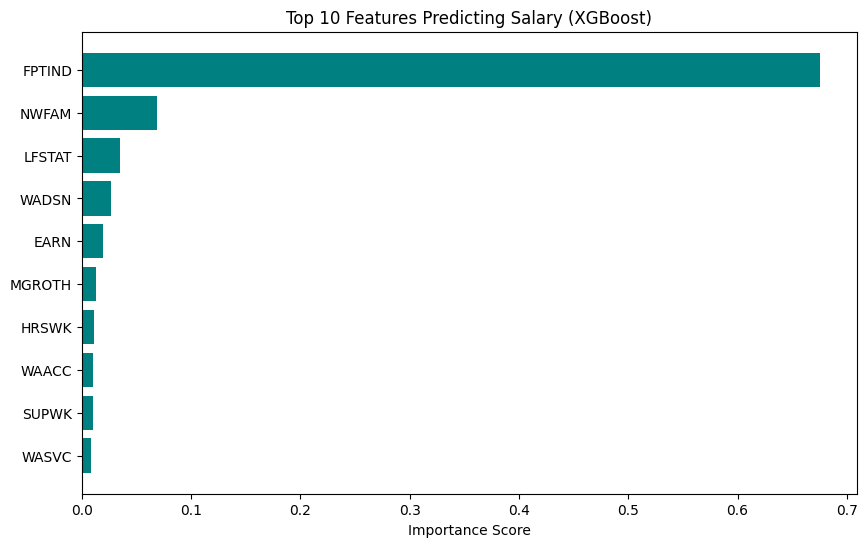

In [8]:
# --- Feature Importance ---
importances = final_model.feature_importances_
feature_names = X.columns
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='teal')
plt.gca().invert_yaxis()
plt.title("Top 10 Features Predicting Salary (XGBoost)")
plt.xlabel("Importance Score")
plt.show()